In [10]:
import torch
import torchvision
import torchvision.transforms as transforms

device = 'cpu'
# device = 'cuda:0'

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cpu


In [30]:
# define the number of epochs + seed
n_epochs = 2
seed_n = 1

# define checkpoint path
PATH_CHECKPOINT = './cifar_net.pth'

# define fair threshold
fair_crit_bound = 0.1  # define the bound on the criterion

In [118]:
# load the data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class_ind = {}

for i, classn in enumerate(classes):
    class_ind[classn] = i

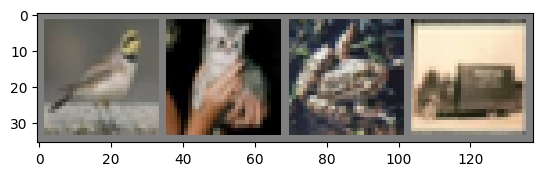

bird  cat   frog  truck


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [11]:
import torch.nn as nn
import torch.nn.functional as F
    
# set the same seed for fair comparisons
torch.manual_seed(seed_n)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [95]:
import torch.optim as optim
from fairret.statistic import Accuracy
from fairret.loss import NormLoss
from humancompatible.train.fairness.utils import BalancedBatchSampler

# define the loss function and the 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# define the criterion
statistic = Accuracy()
fair_criterion = NormLoss(statistic=statistic, p=1)

In [ ]:
def test_network(network):
    
    # prepare count for correct answers
    correct = 0
    total = 0

    # prepare fairness counts

    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # prepare accuracy per group
    soft_acc_per_group = torch.zeros(10)

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = network(images)

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            probs = torch.softmax(outputs, dim=1)
            
            # compute the accuracy overall
            correct += (predicted == labels).sum().item()

            # compute the fairness - soft accuracy per group
            accuracy_per_group = probs.gather(1, labels.unsqueeze(1)).squeeze()

            # compute per class accuracy for this batch
            batch_item_iter = 0
            for label, prediction in zip(labels, predicted):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                
                # add the soft prediction
                soft_acc_per_group[label] += accuracy_per_group[batch_item_iter]
                batch_item_iter += 1

                total_pred[classes[label]] += 1

    # compute the accuracy per class
    for classname, correct_count in correct_pred.items():
        accuracy = float(correct_count) / total_pred[classname]
        soft_acc_per_group[ class_ind[classname] ] /= total_pred[classname]
        correct_pred[classname] = accuracy

    # compute the constraint 
    overall_accuracy = soft_acc_per_group.mean()
    constr = torch.norm(1 - soft_acc_per_group / overall_accuracy, p=1)

    # returns total hard accuracy, hard accuracy per group, soft accuracy per group and accuracy constraint
    return correct / total , correct_pred, soft_acc_per_group, constr

test_network(net)

(0.556,
 {'plane': 0.626,
  'car': 0.607,
  'bird': 0.358,
  'cat': 0.557,
  'deer': 0.499,
  'dog': 0.381,
  'frog': 0.538,
  'horse': 0.579,
  'ship': 0.665,
  'truck': 0.75},
 tensor([0.4952, 0.5017, 0.2655, 0.3402, 0.3268, 0.3260, 0.3985, 0.4470, 0.5067,
         0.5972]),
 tensor(2.1187))

In [15]:
for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.216
[1,  4000] loss: 1.885
[1,  6000] loss: 1.694
[1,  8000] loss: 1.602
[1, 10000] loss: 1.537
[1, 12000] loss: 1.471
[2,  2000] loss: 1.413
[2,  4000] loss: 1.369
[2,  6000] loss: 1.318
[2,  8000] loss: 1.331
[2, 10000] loss: 1.292
[2, 12000] loss: 1.262
Finished Training


In [18]:
torch.save(net.state_dict(), PATH_CHECKPOINT)

In [19]:
net = Net().to(device)
net.load_state_dict(torch.load(PATH_CHECKPOINT, weights_only=True))


<All keys matched successfully>